In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from fastai.text.all import *

set_seed(99, True)

# Create Text Dataloaders

In [3]:
from helpers import path, df

In [4]:
df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


((array([6992.,  114.,  988.,  351.,  657.,   32.,  399.,  377.,  461.,
           36.]),
  array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
  <BarContainer object of 10 artists>),
 Index(['ADT45', 'IR20', 'KarnatakaPonni', 'Onthanel', 'Ponni', 'Surya',
        'Zonal', 'AndraPonni', 'AtchayaPonni', 'RR'],
       dtype='object'))

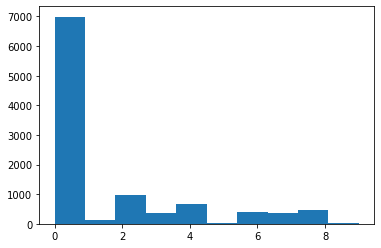

In [54]:
labels, categories = pd.factorize(df.variety)

plt.hist(labels), categories

In [55]:
df.variety.value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [45]:
bs = 128

## Language Model DL

In [30]:
dls = DataBlock(
    blocks=TextBlock.from_df('variety', is_lm=True, seq_len=1),
    get_x=ColReader('text'),
    n_inp=1,
    splitter=RandomSubsetSplitter(train_sz=0.9, valid_sz=0.1),
).dataloaders(df, bs=bs)

dls.show_batch()

,text,text_
0,xxbos,xxup
1,xxup,adt45
2,xxup,adt45
3,xxup,adt45
4,adt45,xxbos
5,onthanel,xxbos
6,xxbos,xxmaj
7,xxmaj,onthanel
8,adt45,xxbos


In [31]:
learn = language_model_learner(dls, AWD_LSTM, metrics=[Perplexity(), accuracy], wd=0.1).to_fp16()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,perplexity,accuracy,time
0,0.818469,0.546564,1.727308,0.852242,01:08


In [33]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,perplexity,accuracy,time
0,0.640244,0.541155,1.717990,0.852582,01:03
1,0.593590,0.516642,1.676389,0.853940,00:59
2,0.646282,0.492965,1.637162,0.853940,00:59
3,0.563902,0.468525,1.597637,0.863791,01:01
4,0.598279,0.460448,1.584784,0.863791,01:04
5,0.530042,0.456519,1.578569,0.863791,01:06
6,0.559889,0.458827,1.582218,0.863791,01:03
7,0.534396,0.455527,1.577004,0.863791,01:03
8,0.598744,0.455914,1.577615,0.863791,01:01
9,0.535166,0.456374,1.578341,0.863791,01:00


In [35]:
learn.save_encoder('lm_encoder')

## Text Classifier DL

In [56]:
dls.vocab

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'adt45',
 'karnatakaponni',
 'ponni',
 'atchayaponni',
 'zonal',
 'andraponni',
 'onthanel',
 'ir20',
 'rr',
 'surya',
 'xxfake',
 'xxfake',
 'xxfake',
 'xxfake',
 'xxfake']

In [77]:
def text_get_items(df):
    return list(zip(df.variety.str.lower(), df.label))

text_dls = TextDataLoaders.from_df(df, valid_pct=0.2, text_col='variety', label_col='label', text_vocab=dls.vocab)

text_dls.show_batch()

,text,category
0,xxbos xxup adt45,normal
1,xxbos xxup adt45,brown_spot
2,xxbos xxmaj ponni,normal
3,xxbos xxup adt45,brown_spot
4,xxbos xxup adt45,hispa
5,xxbos xxmaj ponni,normal
6,xxbos xxmaj ponni,normal
7,xxbos xxup adt45,hispa
8,xxbos xxup adt45,brown_spot


In [78]:
text_learn = text_classifier_learner(text_dls, AWD_LSTM, metrics=[accuracy], drop_mult=0.5)
text_learn = text_learn.load_encoder('lm_encoder')

In [79]:
text_learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.168577,2.075872,0.212398,00:07


In [80]:
text_learn.freeze_to(-2)
text_learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.123937,2.008922,0.303220,00:08


In [81]:
text_learn.freeze_to(-3)
text_learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.092145,1.976460,0.302259,00:08


In [82]:
text_learn.unfreeze()
text_learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.061390,1.956892,0.308025,00:09
1,2.033365,1.949641,0.308025,00:08
2,2.036515,1.962777,0.308025,00:08
3,2.013353,1.947605,0.308025,00:09
4,2.015025,1.941116,0.312350,00:08


# Classifier from helpers

SuggestedLRs(steep=0.033113110810518265, valley=0.0030199517495930195)

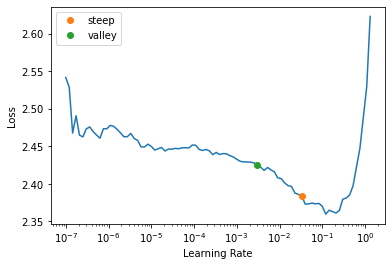

In [75]:
from helpers import get_text_classifier_dls

text_dls = get_text_classifier_dls(bs)

text_learn = text_classifier_learner(text_dls, AWD_LSTM, metrics=[accuracy], drop_mult=0.2)
text_learn = text_learn.load_encoder('lm_encoder')


text_learn.lr_find(suggest_funcs=(steep, valley))

In [76]:
text_learn.fit_one_cycle(10, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.163200,2.073383,0.190774,00:06
1,2.119224,2.073045,0.255646,00:06
2,2.082932,2.082411,0.196060,00:06
3,2.087586,2.025774,0.237866,00:07
4,2.072232,2.001928,0.229217,00:06
5,2.053862,1.960620,0.299375,00:06
6,2.044804,1.968297,0.298414,00:07
7,2.038795,1.960113,0.291206,00:08
8,2.029105,1.952324,0.291206,00:08
9,2.005305,1.935493,0.301297,00:07


# Test w/out finetuned encoder

SuggestedLRs(steep=0.3019951581954956, valley=0.007585775572806597)

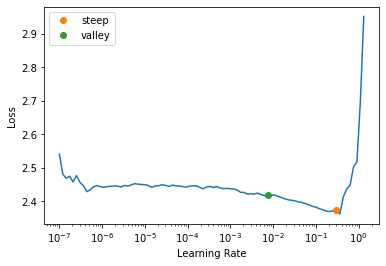

In [83]:
from helpers import get_text_classifier_dls

text_dls = get_text_classifier_dls(bs)

text_learn = text_classifier_learner(text_dls, AWD_LSTM, metrics=[accuracy], drop_mult=0.2)

text_learn.lr_find(suggest_funcs=(steep, valley))

In [84]:
text_learn.fit_one_cycle(10, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.213037,2.068044,0.192215,00:08
1,2.154617,2.130748,0.194137,00:08
2,2.126536,2.179924,0.170111,00:08
3,2.132164,2.118348,0.197021,00:08
4,2.126108,2.076015,0.239789,00:09
5,2.115700,2.094297,0.172513,00:08
6,2.113702,2.080110,0.254205,00:07
7,2.103367,2.077362,0.195579,00:08
8,2.091071,2.046441,0.254205,00:07
9,2.078786,2.046149,0.254205,00:07
